<a href="https://colab.research.google.com/github/NatnaelT/DeepFish/blob/master/Cascade_ShastaReserviourModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data_in_out_cascade.csv to data_in_out_cascade.csv
User uploaded file "data_in_out_cascade.csv" with length 1521611 bytes


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import pyplot

import keras
from keras import optimizers
import math
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
    
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#from numba import jit

import timeit 

start = timeit.default_timer()

In [0]:
# Importing the training set
dataset_tran_test_val_in = pd.read_csv('data_in_out_cascade.csv') #all inputs 2000 - 2017
dataset_tran_test_val_in = np.array(dataset_tran_test_val_in)

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) #For inputs
data_all_2000_2018_in_scaled = sc.fit_transform(dataset_tran_test_val_in)

In [0]:
# Predictors SHASTA PROFILE
training_set_scaled_SHA_P = data_all_2000_2018_in_scaled[:5275,[1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]]

testing_set_scaled_SHA_P = data_all_2000_2018_in_scaled[5275:6207,[1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]]

validation_set_scaled_SHA_P = data_all_2000_2018_in_scaled[6207:-1,[1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]]



# Predictors SHASTA OUTFLOW Tempreature
training_set_scaled_SHA_T = data_all_2000_2018_in_scaled[:5275,[2,15,16,17,18,26,27,28]]

testing_set_scaled_SHA_T = data_all_2000_2018_in_scaled[5275:6207,[2,15,16,17,18,26,27,28]]

validation_set_scaled_SHA_T = data_all_2000_2018_in_scaled[6207:-1,[2,15,16,17,18,26,27,28]]

# Predictors Keswick   Tempreature
training_set_scaled_KWK_T = data_all_2000_2018_in_scaled[:5275,[2,3,4,20,21,22,23,24,25,29]]

testing_set_scaled_KWK_T = data_all_2000_2018_in_scaled[5275:6207,[2,3,4,20,21,22,23,24,25,29]]

validation_set_scaled_KWK_T = data_all_2000_2018_in_scaled[6207:-1,[2,3,4,20,21,22,23,24,25,29]]

## Response SHASTA PROFILE
training_set_scaled_resp_SHA_P = data_all_2000_2018_in_scaled[1:5276,[26, 27,28]]

testing_set_scaled_resp_SHA_P = data_all_2000_2018_in_scaled[5276:6208,[26, 27,28]]

validation_set_scaled_resp_SHA_P = data_all_2000_2018_in_scaled[6208:,[26, 27,28]]

## Response SHASTA OUTFLOW Tempreature
training_set_scaled_resp_SHA_T = data_all_2000_2018_in_scaled[1:5276,29]

testing_set_scaled_resp_SHA_T = data_all_2000_2018_in_scaled[5276:6208,29]

validation_set_scaled_resp_SHA_T = data_all_2000_2018_in_scaled[6208:,29]


## Response Keswick OUTFLOW Tempreature
training_set_scaled_resp_KWK_T = data_all_2000_2018_in_scaled[1:5276,30]

testing_set_scaled_resp_KWK_T = data_all_2000_2018_in_scaled[5276:6208,30]

validation_set_scaled_resp_KWK_T = data_all_2000_2018_in_scaled[6208:,30]


In [0]:
lag_day_SHA_P = 10

lag_day_SHA_T = 5


lag_day_KWK_T = 5


X_train_SHA_P = []
y_train_SHA_P = []

X_train_SHA_T = []
y_train_SHA_T = []

X_train_KWK_T = []
y_train_KWK_T = []

for i in range(lag_day_SHA_P, len(training_set_scaled_SHA_P)):
    X_train_SHA_P.append(training_set_scaled_SHA_P[i-lag_day_SHA_P:i, :]) #Assuming 5 days lag time affects, here discharge temperature not included  
    y_train_SHA_P.append(training_set_scaled_resp_SHA_P[i-1]) #Shashta
    
for i in range(lag_day_SHA_T, len(training_set_scaled_SHA_T)):
    X_train_SHA_T.append(training_set_scaled_SHA_T[i-lag_day_SHA_T:i, :]) #Assuming 5 days lag time affects, here discharge temperature not included  
    y_train_SHA_T.append(training_set_scaled_resp_SHA_T[i-1]) #Shashta

for i in range(lag_day_KWK_T, len(training_set_scaled_KWK_T)):
    X_train_KWK_T.append(training_set_scaled_KWK_T[i-lag_day_KWK_T:i, :]) #Assuming 5 days lag time affects, here discharge temperature not included  
    y_train_KWK_T.append(training_set_scaled_resp_KWK_T[i-1]) #Shashta

X_train_SHA_P, y_train_SHA_P = np.array(X_train_SHA_P), np.array(y_train_SHA_P)

X_train_SHA_T, y_train_SHA_T = np.array(X_train_SHA_T), np.array(y_train_SHA_T)

X_train_KWK_T, y_train_KWK_T = np.array(X_train_KWK_T), np.array(y_train_KWK_T)


# Reshaping
X_train_SHA_P = np.reshape(X_train_SHA_P, (X_train_SHA_P.shape[0], X_train_SHA_P.shape[1], 23))

X_train_SHA_T = np.reshape(X_train_SHA_T, (X_train_SHA_T.shape[0], X_train_SHA_T.shape[1], 8))

X_train_KWK_T = np.reshape(X_train_KWK_T, (X_train_KWK_T.shape[0], X_train_KWK_T.shape[1], 10))

#test_set_scaled = testing_set_scaled_resp_shashta

X_test_SHA_P = []
y_test_SHA_P = []

X_test_SHA_T = []
y_test_SHA_T = []

X_test_KWK_T = []
y_test_KWK_T = []

for i in range(lag_day_SHA_P, len(testing_set_scaled_SHA_P)):
    X_test_SHA_P.append(testing_set_scaled_SHA_P[i-lag_day_SHA_P:i, :])
    y_test_SHA_P.append(testing_set_scaled_resp_SHA_P[i-1])

for i in range(lag_day_SHA_T, len(testing_set_scaled_SHA_T)):
    X_test_SHA_T.append(testing_set_scaled_SHA_T[i-lag_day_SHA_T:i, :])
    y_test_SHA_T.append(testing_set_scaled_resp_SHA_T[i-1])

for i in range(lag_day_KWK_T, len(testing_set_scaled_KWK_T)): 
    X_test_KWK_T.append(testing_set_scaled_KWK_T[i-lag_day_KWK_T:i, :])
    y_test_KWK_T.append(testing_set_scaled_resp_KWK_T[i-1])


X_test_SHA_P, y_test_SHA_P = np.array(X_test_SHA_P), np.array(y_test_SHA_P)

X_test_SHA_T, y_test_SHA_T = np.array(X_test_SHA_T), np.array(y_test_SHA_T)

X_test_KWK_T, y_test_KWK_T = np.array(X_test_KWK_T), np.array(y_test_KWK_T)


# Reshaping for keras formating
X_test_SHA_P = np.reshape(X_test_SHA_P, (X_test_SHA_P.shape[0], X_test_SHA_P.shape[1], 23))

X_test_SHA_T = np.reshape(X_test_SHA_T, (X_test_SHA_T.shape[0], X_test_SHA_T.shape[1], 8))

X_test_KWK_T = np.reshape(X_test_KWK_T, (X_test_KWK_T.shape[0], X_test_KWK_T.shape[1], 10))


# Setup alternating learning rate

In [0]:

#@jit

def get_triangular_lr(epoch):
    """Given the inputs, calculates the lr that should be applicable for this iteration"""
    #num_iterations = 10000

    stepsize = 50
    base_lr = 0.000001
    max_lr = 0.00001
    
    cycle = np.floor(1 + epoch/(2  * stepsize))
    x = np.abs(epoch/stepsize - 2 * cycle + 1)
    lrate = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    return lrate



epoch = 1000

lrate = LearningRateScheduler(get_triangular_lr)
callbacks_list = [lrate]
ln_algorithm = optimizers.Adam(lr=0.000, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08, decay = 0)


# Shasta Profile Temperature Train + Test

In [0]:
###############################################################################

#@jit 
def fit_model_SHA_P(X_train, y_train, X_test, y_test):
    # define model
    model_SHA_P = Sequential()
    model_SHA_P.add(LSTM(units = 23, return_sequences = True, input_shape = (X_train.shape[1], 23)))
    model_SHA_P.add(Dropout(0.2))
    
    model_SHA_P.add(LSTM(units = 23, return_sequences = True))
    model_SHA_P.add(Dropout(0.2))
    
    model_SHA_P.add(LSTM(units = 23))
    model_SHA_P.add(Dropout(0.2))
    
    model_SHA_P.add(Dense(units = 3))
    
    
    
    model_SHA_P.compile(loss = 'mean_squared_error', optimizer = ln_algorithm)
    
    history = model_SHA_P.fit(X_train, y_train, epochs = epoch, batch_size = 128, validation_data = (X_test, y_test),callbacks=callbacks_list,verbose=2)
    
    
    loss_SHA_P_train = history.history['loss'] #model_KWK_T.evaluate(X_test, y_test,verbose=0)
    
    loss_SHA_P_test = history.history['val_loss']
    
    return loss_SHA_P_train, loss_SHA_P_test, model_SHA_P 


# Shasta Outflow Temperature Forcater 

In [0]:
#@jit
def fit_model_SHA_T(X_train, y_train, X_test, y_test):
    # define model
    model_SHA_T = Sequential()
    
    model_SHA_T.add(LSTM(units = 11, return_sequences = True, input_shape = (X_train.shape[1], 8)))
    model_SHA_T.add(Dropout(0.2))
    
    model_SHA_T.add(LSTM(units = 11, return_sequences = True))
    model_SHA_T.add(Dropout(0.2))
#
    model_SHA_T.add(LSTM(units = 11))
    model_SHA_T.add(Dropout(0.2))
    
    
    model_SHA_T.add(Dense(units = 1))
    
    
    
    model_SHA_T.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    history = model_SHA_T.fit(X_train, y_train, epochs = epoch, batch_size = 128, validation_data = (X_test, y_test),callbacks=callbacks_list,verbose=2)
    
    loss_SHA_T_train = history.history['loss'] #model_KWK_T.evaluate(X_test, y_test,verbose=0)
    
    loss_SHA_T_test = history.history['val_loss']
    
    return loss_SHA_T_train, loss_SHA_T_test, model_SHA_T 

# Keswick outflow temperature predictor

In [0]:
#@jit
def fit_model_KWK_T(X_train, y_train, X_test, y_test):
    # define model
    model_KWK_T = Sequential()
    
    model_KWK_T.add(LSTM(units = 13, return_sequences = True, input_shape = (X_train.shape[1], 10)))
    model_KWK_T.add(Dropout(0.2))


    model_KWK_T.add(LSTM(units = 13, return_sequences = True))
    model_KWK_T.add(Dropout(0.2))


    model_KWK_T.add(LSTM(units = 13))
    model_KWK_T.add(Dropout(0.2))
    
    model_KWK_T.add(Dense(units = 1))
    
    model_KWK_T.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    #model_KWK_T.fit(X_train, y_train, epochs = 100, batch_size = 128, verbose=0)
    
    history = model_KWK_T.fit(X_train, y_train, epochs = epoch, batch_size = 128, validation_data = (X_test, y_test),callbacks=callbacks_list,verbose=2)
    
    loss_KWK_T_train = history.history['loss'] #model_KWK_T.evaluate(X_test, y_test,verbose=0)
    
    loss_KWK_T_test = history.history['val_loss']
    
    
    #loss_KWK_T_test = model_KWK_T.evaluate(X_test, y_test,verbose=0)
    
    #historty_KWK_T = model_KWK_T.fit(X_train, y_train, epochs = 100, batch_size = 128, verbose=0)
    
    #model_KWK_T.fit(X_train, y_train, epochs = 100, batch_size = 128, validation_data = (X_test, y_test),verbose=0)
    
    #loss_KWK_T_train = historty.historty['loss'] #model_KWK_T.evaluate(X_test, y_test,verbose=0)
    
    #loss_KWK_T_test = historty.historty['val_loss']
    
    return loss_KWK_T_train, loss_KWK_T_test, model_KWK_T

# Training - Testing error history

In [18]:
###############################################################################

loss_SHA_P_train, loss_SHA_P_test, model_SHA_P = fit_model_SHA_P(X_train_SHA_P, y_train_SHA_P,X_test_SHA_P, y_test_SHA_P)

loss_SHA_T_train, loss_SHA_T_test, model_SHA_T = fit_model_SHA_T(X_train_SHA_T, y_train_SHA_T,X_test_SHA_T, y_test_SHA_T)

loss_KWK_T_train, loss_KWK_T_test, model_KWK_T = fit_model_KWK_T(X_train_KWK_T, y_train_KWK_T,X_test_KWK_T, y_test_KWK_T)




###############################################################################

Train on 5265 samples, validate on 922 samples
Epoch 1/1000
 - 4s - loss: 0.0804 - val_loss: 0.1598
Epoch 2/1000
 - 1s - loss: 0.0800 - val_loss: 0.1592
Epoch 3/1000
 - 1s - loss: 0.0795 - val_loss: 0.1586
Epoch 4/1000
 - 1s - loss: 0.0794 - val_loss: 0.1579
Epoch 5/1000
 - 1s - loss: 0.0787 - val_loss: 0.1571
Epoch 6/1000
 - 1s - loss: 0.0780 - val_loss: 0.1562
Epoch 7/1000
 - 1s - loss: 0.0773 - val_loss: 0.1553
Epoch 8/1000
 - 1s - loss: 0.0766 - val_loss: 0.1543
Epoch 9/1000
 - 1s - loss: 0.0758 - val_loss: 0.1532
Epoch 10/1000
 - 1s - loss: 0.0750 - val_loss: 0.1521
Epoch 11/1000
 - 1s - loss: 0.0742 - val_loss: 0.1509
Epoch 12/1000
 - 1s - loss: 0.0732 - val_loss: 0.1496
Epoch 13/1000
 - 1s - loss: 0.0723 - val_loss: 0.1482
Epoch 14/1000
 - 1s - loss: 0.0713 - val_loss: 0.1468
Epoch 15/1000
 - 1s - loss: 0.0703 - val_loss: 0.1453
Epoch 16/1000
 - 1s - loss: 0.0692 - val_loss: 0.1437
Epoch 17/1000
 - 1s - loss: 0.0679 - val_loss: 0.1421
Epoch 18/1000
 - 1s - loss: 0.0668 - val_los

In [19]:
#This part is forked from https://stackoverflow.com/questions/48924165/google-colaboratory-weight-download-export-saved-models
# Checkout https://github.com/MerceaOtniel/Google-Colaboratory-Tensorboard-Setup/blob/master/deep_learning_turkey.ipynb


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
#model.save('model.h5')  

model_SHA_P.save('shasta_profile.h5')

model_SHA_T.save('shasta_temp.h5')

model_KWK_T.save('keswick_temp.h5')


#model_file = drive.CreateFile({'title' : 'model.h5'})

model_SHA_P_file = drive.CreateFile({'title' : 'shasta_profile.h5'})

model_SHA_T_file = drive.CreateFile({'title' : 'shasta_temp.h5'})

model_KWK_T_file = drive.CreateFile({'title' : 'keswick_temp.h5'})



#model_file.SetContentFile('model.h5')

model_SHA_P_file.SetContentFile('shasta_profile.h5')

model_SHA_T_file.SetContentFile('shasta_temp.h5')

model_KWK_T_file.SetContentFile('keswick_temp.h5')


#model_file.Upload()


model_SHA_P_file.Upload()

model_SHA_T_file.Upload()

model_KWK_T_file.Upload()

# download to google drive
#drive.CreateFile({'id': model_file.get('id')})


drive.CreateFile({'id': model_SHA_P_file.get('id')})

drive.CreateFile({'id': model_SHA_T_file.get('id')})

drive.CreateFile({'id': model_KWK_T_file.get('id')})

GoogleDriveFile({'id': '1vQ78UR247XSrY3Uxui1t9LoMxthd8K45'})

In [0]:
### SAVE MODELS

model_SHA_P.save('shasta_profile_update.h5')

model_SHA_T.save('shasta_temp_update.h5')

model_KWK_T.save('keswick_temp_update.h5')


model_SHA_P.save_weights('shasta_profile_weights_update.h5')

model_SHA_T.save_weights('shasta_temp_weights_update.h5')

model_KWK_T.save_weights('keswick_temp_weights_update.h5')

In [0]:
total_train_loss = loss_SHA_P_train + loss_SHA_T_train + loss_KWK_T_train 

total_test_loss = loss_SHA_P_test + loss_SHA_T_test + loss_KWK_T_test

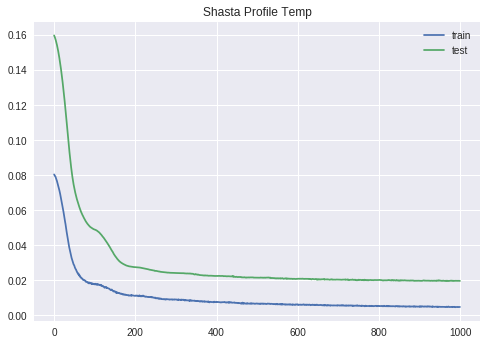

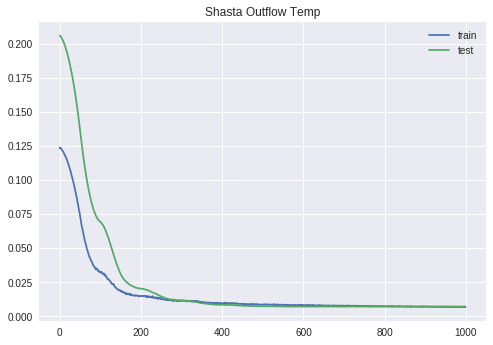

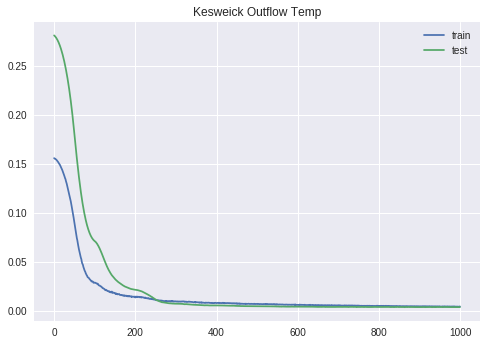

In [22]:
from matplotlib import pyplot
#pyplot.subplot(311)
pyplot.plot(loss_SHA_P_train, label='train')
pyplot.plot(loss_SHA_P_test, label='test')
pyplot.title('Shasta Profile Temp')
pyplot.legend()
pyplot.show()

#pyplot.subplot(312)
pyplot.plot(loss_SHA_T_train, label='train')
pyplot.plot(loss_SHA_T_test, label='test')
pyplot.title('Shasta Outflow Temp')
pyplot.legend()
pyplot.show()


#pyplot.subplot(313)
pyplot.plot(loss_KWK_T_train, label='train')
pyplot.plot(loss_KWK_T_test, label='test')
pyplot.title('Kesweick Outflow Temp')
pyplot.legend()
pyplot.show()

In [0]:
X_valdidation_SHA_P = []

X_valdidation_SHA_T = []

X_valdidation_KWK_T = []

for i in range(lag_day_SHA_P, len(validation_set_scaled_SHA_P)):
    
    X_valdidation_SHA_P.append(validation_set_scaled_SHA_P[i-lag_day_SHA_P:i, :]) #predictors of the year 2017

for i in range(lag_day_SHA_T, len(validation_set_scaled_SHA_T)):
    
    X_valdidation_SHA_T.append(validation_set_scaled_SHA_T[i-lag_day_SHA_T:i, :])
    
for i in range(lag_day_KWK_T, len(validation_set_scaled_KWK_T)):
    
    X_valdidation_KWK_T.append(validation_set_scaled_KWK_T[i-lag_day_SHA_T:i, :])


X_valdidation_SHA_P = np.array(X_valdidation_SHA_P)

X_valdidation_SHA_T = np.array(X_valdidation_SHA_T)

X_valdidation_KWK_T = np.array(X_valdidation_KWK_T)

In [0]:
# Reshaping
X_valdidation_SHA_P = np.reshape(X_valdidation_SHA_P, (X_valdidation_SHA_P.shape[0], X_valdidation_SHA_P.shape[1], 23))


X_valdidation_SHA_T = np.reshape(X_valdidation_SHA_T, (X_valdidation_SHA_T.shape[0], X_valdidation_SHA_T.shape[1], 8))


X_valdidation_KWK_T = np.reshape(X_valdidation_KWK_T, (X_valdidation_KWK_T.shape[0], X_valdidation_KWK_T.shape[1], 10))



predicted_scled_SHA_P = model_SHA_P.predict(X_valdidation_SHA_P)


predicted_scled_SHA_T = model_SHA_T.predict(X_valdidation_SHA_T)


predicted_scled_KWK_T = model_KWK_T.predict(X_valdidation_KWK_T)



sc1 = MinMaxScaler(feature_range = (0, 1)) 

sc2 = MinMaxScaler(feature_range = (0, 1))

sc3 = MinMaxScaler(feature_range = (0, 1)) 

In [0]:
data_all_SHA_P = sc1.fit_transform(dataset_tran_test_val_in[:,[26,27,28]])


data_all_SHA_T = sc2.fit_transform(dataset_tran_test_val_in[:,29].reshape(-1, 1))


data_all_KWK_T = sc3.fit_transform(dataset_tran_test_val_in[:,30].reshape(-1, 1))



data_observed_SHA_P = dataset_tran_test_val_in[6208:,[26, 27,28]]


data_observed_SHA_T = dataset_tran_test_val_in[6208:,29]


data_observed_KWK_T = dataset_tran_test_val_in[6208:,30]


#data_observed_middle = data_observed[:,0]


predicted_temp_SHA_P = sc1.inverse_transform(predicted_scled_SHA_P)


predicted_temp_SHA_T = sc2.inverse_transform(predicted_scled_SHA_T)


predicted_temp_KWK_T = sc3.inverse_transform(predicted_scled_KWK_T)

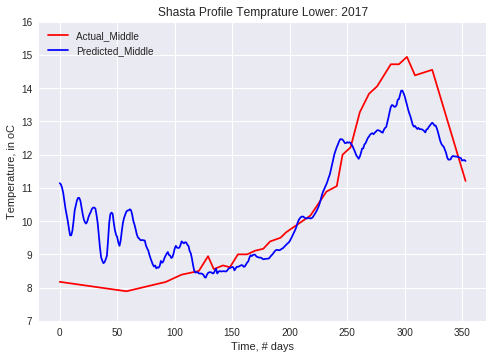

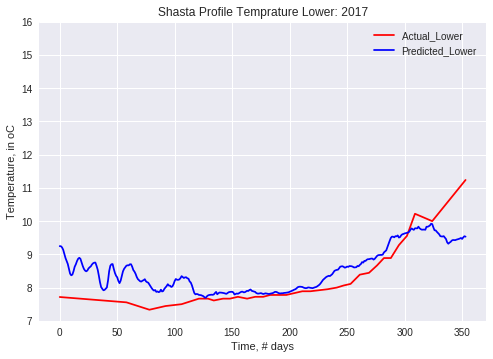

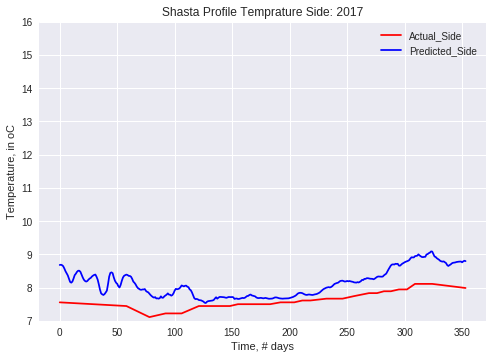

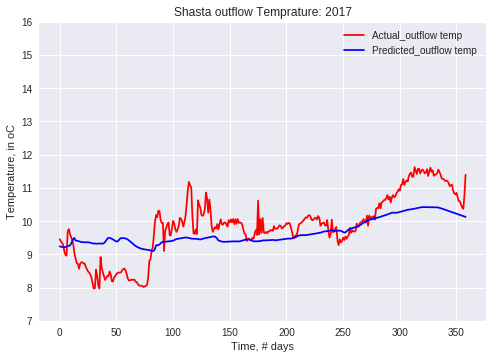

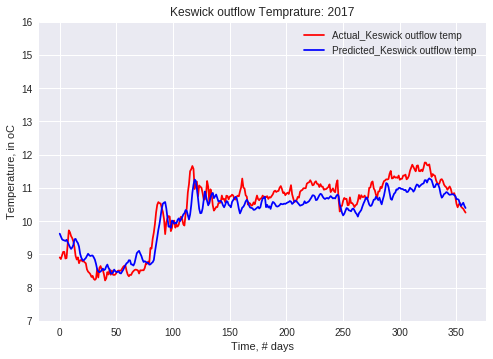

In [26]:
#############################################
#Result visualization

plt.plot(data_observed_SHA_P[lag_day_SHA_P:,0], color = 'red', label = 'Actual_Middle ')
plt.plot(predicted_temp_SHA_P[:,0], color = 'blue', label = 'Predicted_Middle')
plt.title('Shasta Profile Temprature Lower: 2017')
plt.ylim(7, 16)
plt.grid(True)
plt.xlabel('Time, # days')
plt.ylabel('Temperature, in oC')
plt.legend()
plt.show()




plt.plot(data_observed_SHA_P[lag_day_SHA_P:,1], color = 'red', label = 'Actual_Lower ')
plt.plot(predicted_temp_SHA_P[:,1], color = 'blue', label = 'Predicted_Lower')
plt.title('Shasta Profile Temprature Lower: 2017')
plt.ylim(7, 16)
plt.grid(True)
plt.xlabel('Time, # days')
plt.ylabel('Temperature, in oC')
plt.legend()
plt.show()


# Visualising the results: Raw
#plt.subplot(133)
plt.plot(data_observed_SHA_P[lag_day_SHA_P:,2], color = 'red', label = 'Actual_Side')
plt.plot(predicted_temp_SHA_P[:,2], color = 'blue', label = 'Predicted_Side')
plt.title('Shasta Profile Temprature Side: 2017')
plt.ylim(7, 16)
plt.grid(True)
plt.xlabel('Time, # days')
plt.ylabel('Temperature, in oC')
plt.legend()
plt.show()



plt.plot(data_observed_SHA_T[lag_day_SHA_T:], color = 'red', label = 'Actual_outflow temp ')
plt.plot(predicted_temp_SHA_T[:], color = 'blue', label = 'Predicted_outflow temp')
plt.title('Shasta outflow Temprature: 2017')
plt.ylim(7, 16)
plt.grid(True)
plt.xlabel('Time, # days')
plt.ylabel('Temperature, in oC')
plt.legend()
plt.show()




plt.plot(data_observed_KWK_T[lag_day_KWK_T:], color = 'red', label = 'Actual_Keswick outflow temp ')
plt.plot(predicted_temp_KWK_T[:], color = 'blue', label = 'Predicted_Keswick outflow temp')
plt.title('Keswick outflow Temprature: 2017')
plt.ylim(7, 16)
plt.grid(True)
plt.xlabel('Time, # days')
plt.ylabel('Temperature, in oC')
plt.legend()
plt.show()


In [27]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse_SHA_P_middle = sqrt(mean_squared_error(data_observed_SHA_P[lag_day_SHA_P:,0], predicted_temp_SHA_P[:,0]))
rmse_SHA_P_low = sqrt(mean_squared_error(data_observed_SHA_P[lag_day_SHA_P:,1], predicted_temp_SHA_P[:,1]))
rmse_SHA_P_side = sqrt(mean_squared_error(data_observed_SHA_P[lag_day_SHA_P:,2], predicted_temp_SHA_P[:,2]))

rmse_SHA_T = sqrt(mean_squared_error(data_observed_SHA_T[lag_day_SHA_T:], predicted_temp_SHA_T[:]))
rmse_KWK_T = sqrt(mean_squared_error(data_observed_KWK_T[lag_day_KWK_T:], predicted_temp_KWK_T[:]))


print('Validation RMSE Shasta Profile Middle: %.3f' % rmse_SHA_P_middle)
print('Validation RMSE Shasta Profile Lower: %.3f' % rmse_SHA_P_low)
print('Validation RMSE Shasta Profile side: %.3f' % rmse_SHA_P_side)

print('Validation RMSE Shasta outflow temp: %.3f' % rmse_SHA_T)
print('Validation RMSE Keswick outflow temp: %.3f' % rmse_SHA_T)


stop = timeit.default_timer()

total_hr = (stop-start)/3600

print(stop-start)

print(total_hr)


Validation RMSE Shasta Profile Middle: 1.196
Validation RMSE Shasta Profile Lower: 0.642
Validation RMSE Shasta Profile side: 0.591
Validation RMSE Shasta outflow temp: 0.698
Validation RMSE Keswick outflow temp: 0.698
2867.8183941609996
0.7966162206002777
